# Predicting Used Car Prices with Machine Learning

## Project Overview

Rusty Bargain, a used car sales service, is developing an app to help users quickly estimate the market value of their vehicles. The goal is to build a machine learning model that can accurately predict car prices based on historical sales data, including technical specifications, trim versions, and pricing trends.

For this project, the key priorities are:

- **Accuracy** – Ensuring the model makes reliable price predictions
- **Speed** – Optimizing prediction times for a smooth user experience
- **Efficiency** – Keeping training times reasonable for practical deployment

The final model will balance these factors to deliver the best results for Rusty Bargain’s app.



## Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import time
from sklearn.linear_model import Ridge


from sklearn.metrics import root_mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Data Preprocessing

## Load data


In [2]:
try: 
    data = pd.read_csv('../data/car_data.csv')
    print("File loaded data locally")
except FileNotFoundError: 
    data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv')
    print("File loaded from the server")

File loaded data locally


**Checking the data**

In [3]:
# Taking a look at the data
print(data.sample(10), "\n")

print(data.info(), "\n")

print("Missing values: \n", data.isnull().sum(), "\n")
print("Duplicated rows: \n", data.duplicated().sum())

             DateCrawled  Price  VehicleType  RegistrationYear Gearbox  Power  \
286439  03/04/2016 13:56   4500        wagon              2001    auto    116   
57565   19/03/2016 15:45   2950        small              2008  manual     68   
125353  16/03/2016 20:39   1350        small              1995  manual     75   
294647  12/03/2016 17:41   1500        sedan              1998  manual    101   
211955  13/03/2016 18:48  10500          NaN              1995  manual    280   
45570   14/03/2016 15:58  12500        small              2013  manual     75   
220344  23/03/2016 19:56   8599        wagon              2009  manual    143   
273382  30/03/2016 08:55   6200  convertible              2007  manual    145   
117909  23/03/2016 13:58   9000        small              2013  manual     73   
54555   25/03/2016 15:54    600        small              1999    auto     75   

          Model  Mileage  RegistrationMonth  FuelType          Brand  \
286439    other   150000            

In [4]:
# Drop duplicates
data = data.drop_duplicates()
print("New shape after dropping duplicates", data.shape)

New shape after dropping duplicates (354107, 16)


## Data Cleaning and Transformation

**Converting column types and handling date formats**

**Handling missing values**

In [5]:
nan_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

# Check the unique values before replacing
for col in nan_columns:
    print(data[col].unique(), "\n")

# Replacing the NaNs with "unknown"
data[nan_columns] = data[nan_columns].fillna("unknown")

# Check if NaNs were successfully removed
print("Remaining NaNs:\n", data.isna().sum())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

['manual' 'auto' nan] 

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy'

In [6]:
# Convert date columns
date_columns = ['DateCrawled', 'DateCreated','LastSeen']

for col in date_columns:
    try:
        data[col] = pd.to_datetime(data[col], format='%d/%m/%Y %H:%M') # Try converting to datetime
        print("Successfully converted to datetime")
    except Exception as e:
        print("Could not be converted:", e)

Successfully converted to datetime
Successfully converted to datetime
Successfully converted to datetime


**Addressing incorrect 'Model' namess**

I noticed there are car models in German. We'll fix those values.

In [7]:
# Make sure all the car models are lowercase
data['Model'] = data['Model'].str.lower()

# Fix the range rover issues
unique_models = sorted(data['Model'].unique())

print("Before changes: \n", unique_models)

Before changes: 
 ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fox', 'freel

In [8]:
# Mapping the German to English, keeping underscores
replacement_dict = {
    '1_reihe': '1_series', '1er': '1_series', 'serie_1': '1_series',
    '2_reihe': '2_series', 'serie_2': '2_series',
    '3_reihe': '3_series', '3er': '3_series', 'serie_3': '3_series',
    '4_reihe': '4_series',
    '5_reihe': '5_series', '5er': '5_series',
    '6_reihe': '6_series', '6er': '6_series',
    '7er': '7_series',
    'c_klasse': 'c_class',
    'e_klasse': 'e_class',
    'm_klasse': 'm_class',
    's_klasse': 's_class',
    'v_klasse': 'v_class',
    
    # Range Rover fixes
    'rangerover': 'range_rover',
    
    # Other car series fixes
    'c_reihe': 'c_series',
    'cr_reihe': 'cr_series',
    'cx_reihe': 'cx_series',
    'i_reihe': 'i_series',
    'm_reihe': 'm_series',
    'mx_reihe': 'mx_series',
    'rx_reihe': 'rx_series',
    'x_reihe': 'x_series',
    'xc_reihe': 'xc_series',
    'z_reihe': 'z_series',
    'tt': 'audi_tt'  # To make it more clear it's a model
    
}

# Apply the changes
data['Model'] = data['Model'].replace(replacement_dict)

# Check the new unique models after translation
after_changes = sorted(data['Model'].unique())
print("After Changes: \n", after_changes, "\n")


# Comparing the changes to check 
print(len(unique_models), len(after_changes), "\n")

print(data['Model'].value_counts())

After Changes: 
 ['100', '145', '147', '156', '159', '1_series', '200', '2_series', '300c', '3_series', '4_series', '500', '5_series', '601', '6_series', '7_series', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'audi_tt', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_class', 'c_max', 'c_series', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_series', 'croma', 'crossfire', 'cuore', 'cx_series', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_class', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fox', 'freelander'

In [9]:
# Correcting 'FuelType' 
data['FuelType'].value_counts()

# Mapping fuel types

fuel_dict = {
    'petrol': 'gasoline',
    'lpg': 'natural_gas', 'cng': 'natural_gas'
}

data['FuelType'] = data['FuelType'].replace(fuel_dict)

print(data['FuelType'].value_counts())

FuelType
gasoline       314819
unknown         32889
natural_gas      5872
hybrid            233
other             204
electric           90
Name: count, dtype: int64


**Addressing the numerical column data**

In [10]:
# Cleaning `RegistrationYear`

# Set some logical bounds to the year data
min_year = 1910
max_year = 2020

# Replace extreme years with NaN
data['RegistrationYear'] = data['RegistrationYear'].where(data['RegistrationYear'].between(min_year, max_year))
data['RegistrationYear'] = data['RegistrationYear'].fillna(np.NaN)

# Percentage of NaNs
print(data['RegistrationYear'].isna().sum()/len(data['RegistrationYear']))

# Dropping the NaNs in 'RegistrationYear'
data = data.dropna(subset=['RegistrationYear'])
data['RegistrationYear'] = data['RegistrationYear'].astype('int') # Convert to int

# Checking our work
print(data['RegistrationYear'].isna().sum()) 

0.00048290488468174874
0


In [11]:
# Cleaning 'RegistrationMonth'
print("RegistrationMonth value counts:", data['RegistrationMonth'].value_counts())

# Replacing '0' values with NaN
data['RegistrationMonth'] = data['RegistrationMonth'].replace(0, None)

RegistrationMonth value counts: RegistrationMonth
0     37215
3     34343
6     31464
4     29242
5     29127
7     27183
10    26075
12    24269
11    24165
9     23796
1     23197
8     22609
2     21251
Name: count, dtype: int64


In [12]:
# Filling the NaNs in with median month
data_heatmap = data.copy()
data_heatmap['RegistrationMonth'] = data_heatmap['RegistrationMonth'].fillna(data_heatmap['RegistrationMonth'].median())

/var/folders/8p/b88wy49j5cz5wcfnmlkzbmlc0000gn/T/ipykernel_83572/3121372650.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_heatmap['RegistrationMonth'] = data_heatmap['RegistrationMonth'].fillna(data_heatmap['RegistrationMonth'].median())


/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


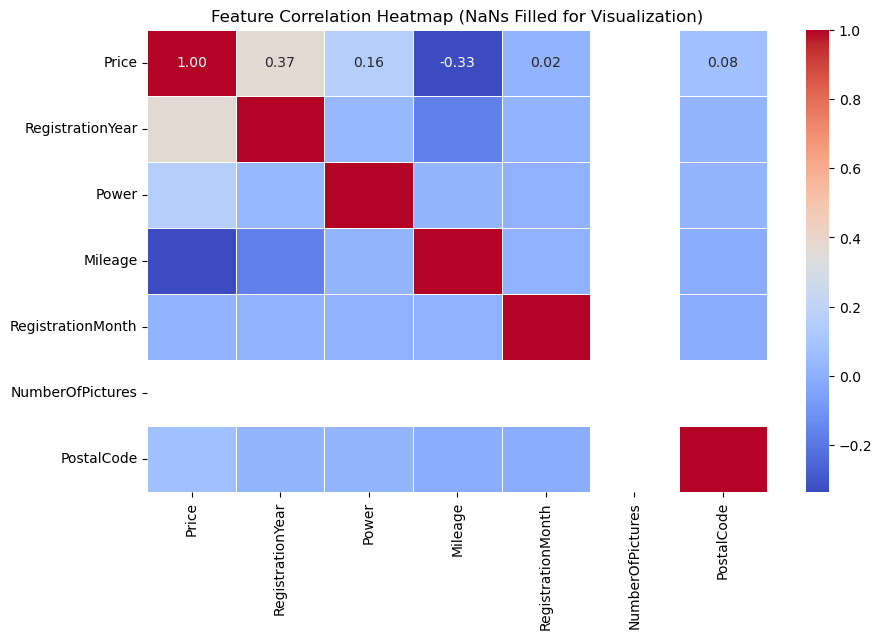

In [13]:
# Creating a heatmap to assess correlation with price
# Corr matrix
corr_matrix = data_heatmap.select_dtypes(include=['number']).corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (NaNs Filled for Visualization)")
plt.show()

# Since`RegistrationMonth` has a low corr value, we drop it
data = data.drop('RegistrationMonth', axis=1)

**Fixing Outliers**

Power
0       40091
75      23998
60      15879
150     14571
101     13286
        ...  
2461        1
6006        1
5815        1
6018        1
1241        1
Name: count, Length: 711, dtype: int64


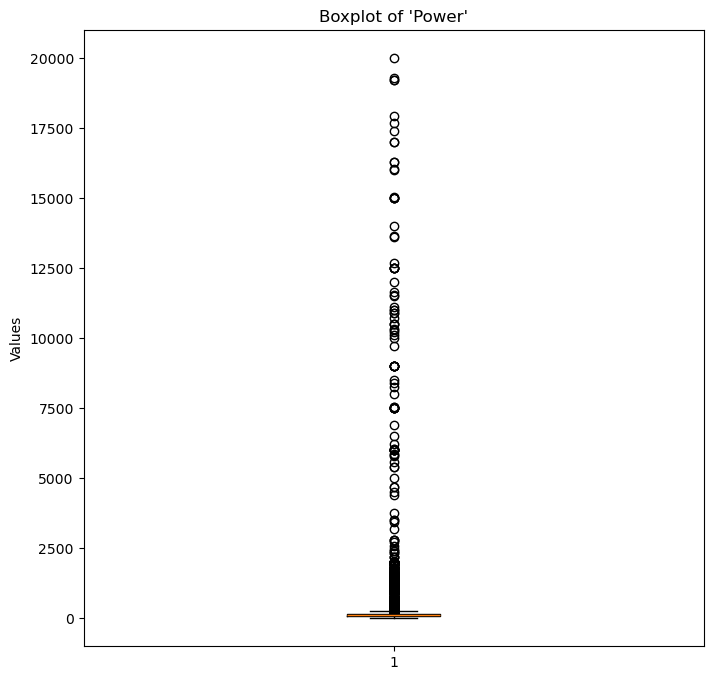

count    353936.000000
mean        110.073542
std         189.601238
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


In [14]:
# Examining the 'Power' outliers
print(data['Power'].value_counts())

# Create a boxplot for 'Power'
plt.figure(figsize=(8,8))
plt.boxplot(data['Power'])
plt.title('Boxplot of \'Power\'')
plt.ylabel('Values')
plt.show()

print(data['Power'].describe())

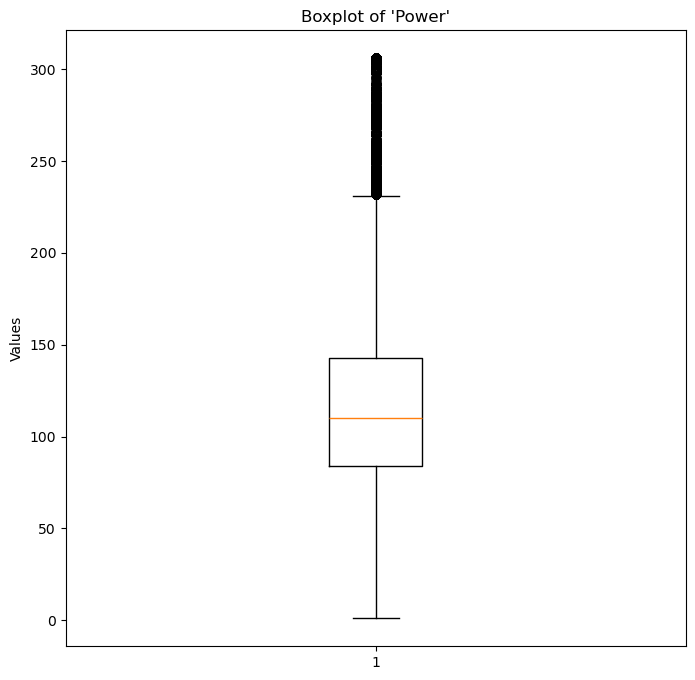

count    353936.000000
mean        118.816181
std          49.455662
min           1.000000
25%          84.000000
50%         110.000000
75%         143.000000
max         306.000000
Name: Power, dtype: float64


In [15]:
# Fix 'Power' outliers 
max_power_threshold = data[data['Power'] > 0]['Power'].quantile(0.99)
median_power = data[(data['Power'] > 0) & (data['Power'] <= max_power_threshold)]['Power'].median()


# Cap the extreme values
data.loc[data['Power'] > max_power_threshold, 'Power'] = max_power_threshold

# Replace zero values with the new median
data.loc[data['Power'] == 0, 'Power'] = median_power

# Create a boxplot for new 'Power' values
plt.figure(figsize=(8,8))
plt.boxplot(data['Power'])
plt.title('Boxplot of \'Power\'')
plt.ylabel('Values')
plt.show()

# Checking our work
print(data['Power'].describe())

In [16]:
# Cleaning the 'NumberofPictures' column
print(data['NumberOfPictures'].unique())

data = data.drop('NumberOfPictures', axis=1)

[0]


**Checking our work**

In [17]:
# Check our work
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353936 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DateCrawled       353936 non-null  datetime64[ns]
 1   Price             353936 non-null  int64         
 2   VehicleType       353936 non-null  object        
 3   RegistrationYear  353936 non-null  int64         
 4   Gearbox           353936 non-null  object        
 5   Power             353936 non-null  int64         
 6   Model             353936 non-null  object        
 7   Mileage           353936 non-null  int64         
 8   FuelType          353936 non-null  object        
 9   Brand             353936 non-null  object        
 10  NotRepaired       353936 non-null  object        
 11  DateCreated       353936 non-null  datetime64[ns]
 12  PostalCode        353936 non-null  int64         
 13  LastSeen          353936 non-null  datetime64[ns]
dtypes: dateti

In [18]:
# Reviewing the numerical columns
data.describe()

,DateCrawled,Price,RegistrationYear,Power,Mileage,DateCreated,PostalCode,LastSeen
count,353936,353936.000000,353936.000000,353936.000000,353936.000000,353936,353936.000000,353936
mean,2016-03-21 12:56:37.289623296,4417.428453,2003.084846,118.816181,128268.288617,2016-03-20 19:11:01.461958912,50510.251308,2016-03-29 23:50:55.514613248
min,2016-03-05 14:06:00,0.000000,1910.000000,1.000000,5000.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:52:00,1050.000000,1999.000000,84.000000,125000.000000,2016-03-13 00:00:00,30165.000000,2016-03-23 02:50:00
50%,2016-03-21 17:50:00,2700.000000,2003.000000,110.000000,150000.000000,2016-03-21 00:00:00,49413.000000,2016-04-03 15:15:00
75%,2016-03-29 14:36:00,6400.000000,2008.000000,143.000000,150000.000000,2016-03-29 00:00:00,71083.000000,2016-04-06 10:15:00
max,2016-04-07 14:36:00,20000.000000,2019.000000,306.000000,150000.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,4514.261174,7.537331,49.455662,37824.728828,NaN,25784.581168,NaN


In [19]:
data.shape

(353936, 14)

In [20]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:00,480,unknown,1993,manual,110,golf,150000,gasoline,volkswagen,unknown,2016-03-24,70435,2016-04-07 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:00
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:00
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:00
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:00
5,2016-04-04 17:36:00,650,sedan,1995,manual,102,3_series,150000,gasoline,bmw,yes,2016-04-04,33775,2016-04-06 19:17:00
6,2016-04-01 20:48:00,2200,convertible,2004,manual,109,2_series,150000,gasoline,peugeot,no,2016-04-01,67112,2016-04-05 18:18:00
7,2016-03-21 18:54:00,0,sedan,1980,manual,50,other,40000,gasoline,volkswagen,no,2016-03-21,19348,2016-03-25 16:47:00
8,2016-04-04 23:42:00,14500,bus,2014,manual,125,c_max,30000,gasoline,ford,unknown,2016-04-04,94505,2016-04-04 23:42:00
9,2016-03-17 10:53:00,999,small,1998,manual,101,golf,150000,unknown,volkswagen,unknown,2016-03-17,27472,2016-03-31 17:17:00


# Exploratory Data Analysis (EDA )

Taking a closer look at: 
- What features seem most related to price?
- Are there any extreme values that should be removed?
- Are there any patterns that could improve the model?


## Summary statistics

In [21]:
data.describe()

,DateCrawled,Price,RegistrationYear,Power,Mileage,DateCreated,PostalCode,LastSeen
count,353936,353936.000000,353936.000000,353936.000000,353936.000000,353936,353936.000000,353936
mean,2016-03-21 12:56:37.289623296,4417.428453,2003.084846,118.816181,128268.288617,2016-03-20 19:11:01.461958912,50510.251308,2016-03-29 23:50:55.514613248
min,2016-03-05 14:06:00,0.000000,1910.000000,1.000000,5000.000000,2014-03-10 00:00:00,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:52:00,1050.000000,1999.000000,84.000000,125000.000000,2016-03-13 00:00:00,30165.000000,2016-03-23 02:50:00
50%,2016-03-21 17:50:00,2700.000000,2003.000000,110.000000,150000.000000,2016-03-21 00:00:00,49413.000000,2016-04-03 15:15:00
75%,2016-03-29 14:36:00,6400.000000,2008.000000,143.000000,150000.000000,2016-03-29 00:00:00,71083.000000,2016-04-06 10:15:00
max,2016-04-07 14:36:00,20000.000000,2019.000000,306.000000,150000.000000,2016-04-07 00:00:00,99998.000000,2016-04-07 14:58:00
std,NaN,4514.261174,7.537331,49.455662,37824.728828,NaN,25784.581168,NaN


In [22]:
# Check the summary statistics 
data.describe(include=['object'])  # Summary of categorical features

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,353936,353936,353936,353936,353936,353936
unique,9,3,243,6,40,3
top,sedan,manual,golf,gasoline,volkswagen,no
freq,91399,268008,29201,314778,76924,246912


## Understanding How 'Price' is Distributed

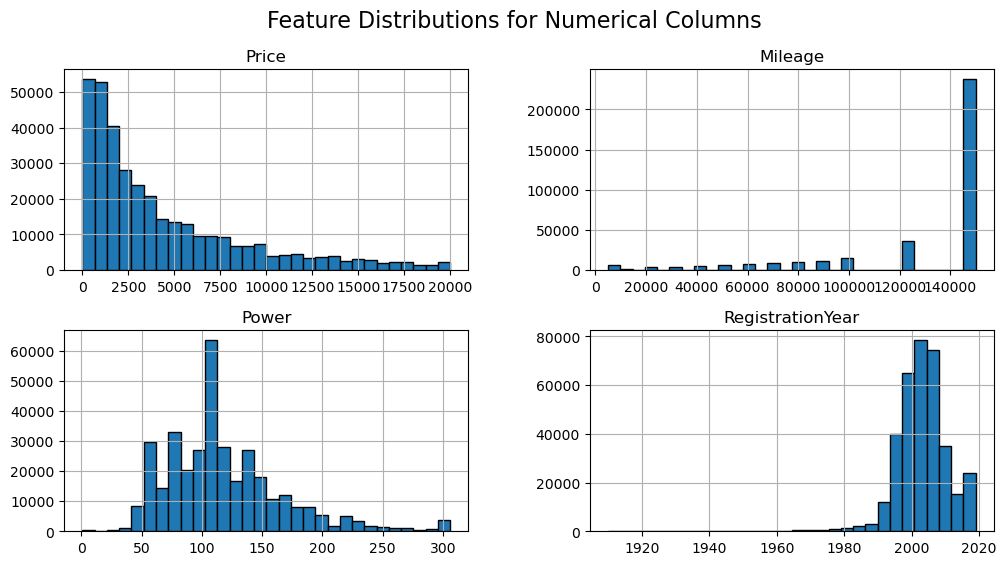

In [23]:
# Visualizing the originally numeric features
original_numeric = ['Price', 'Mileage', 'Power', 'RegistrationYear']

# Plot histograms for original numerical features
data[original_numeric].hist(figsize=(12, 6), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions for Numerical Columns", fontsize=16)
plt.show()

In [24]:
zero_price_count = data[data['Price'] == 0].shape[0]
print("Number of zero price listings:", zero_price_count)

Number of zero price listings: 10738


There is a heavy skew to the 'Price' column and we do have a large number of cars priced at zero. It's not clear if that's an error or if it's intentional. (For example, "Contact for price.") 

The number of zero price listings seems significant, so I'll do a log transform to reduce the skew and improve model performance. 

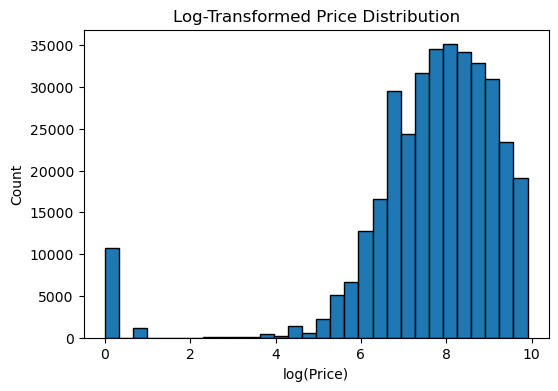

In [25]:
# Apply log transformation
data['log_price'] = np.log1p(data['Price'])  # log1p helps handle zeros safely

# Plot histogram of log-transformed price
plt.figure(figsize=(6,4))
plt.hist(data['log_price'], bins=30, edgecolor='black')
plt.title("Log-Transformed Price Distribution")
plt.xlabel("log(Price)")
plt.ylabel("Count")
plt.show()

## Examining Feature Relationships with Price



**Correlation Heatmap** 

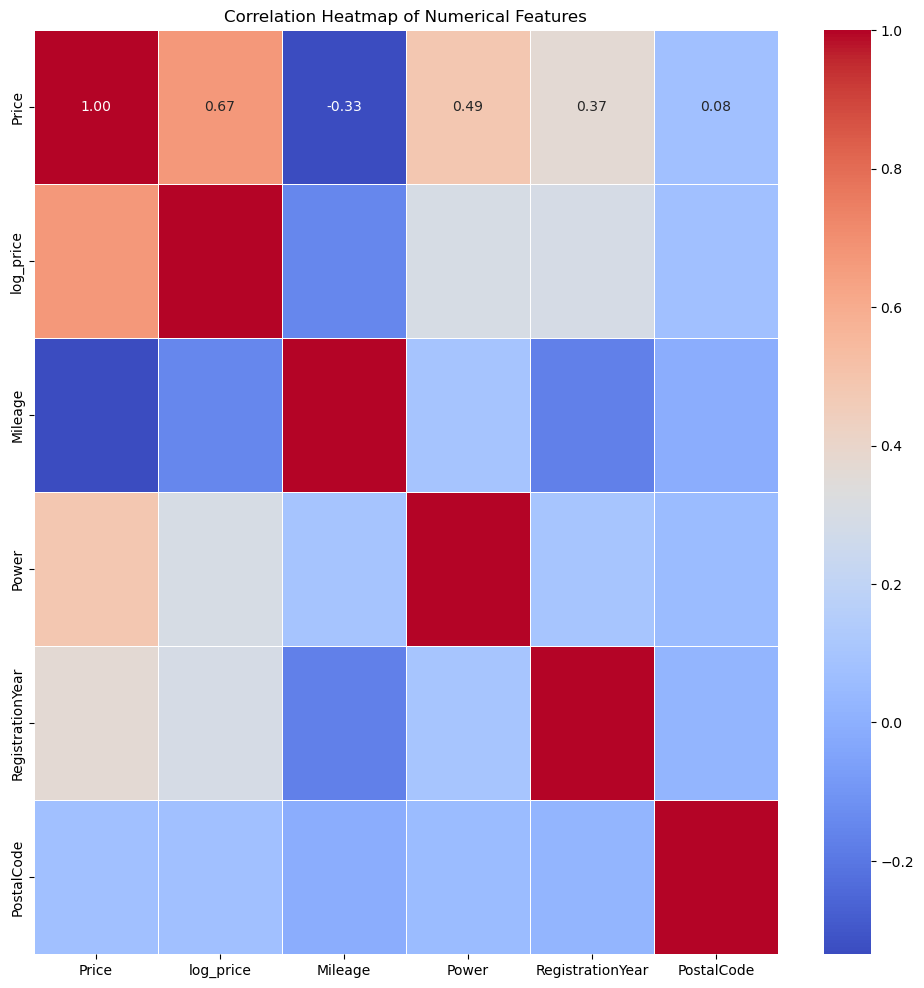

In [26]:
# Heatmap for the numeric features 
corr_feature_matrix = data[['Price', 'log_price', 'Mileage', 'Power', 'RegistrationYear', 'PostalCode']].corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_feature_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Interpreting the correlation matrix: 

- `Power` and `RegistrationYear` seem like the strongest predictors of price.
- `Mileage` matters, but its effect is weaker than expected.
- `log_price` has a slightly weaker correlation with features than `Price`. 

## Visualizing 'Brand' and 'Model' vs 'Price'

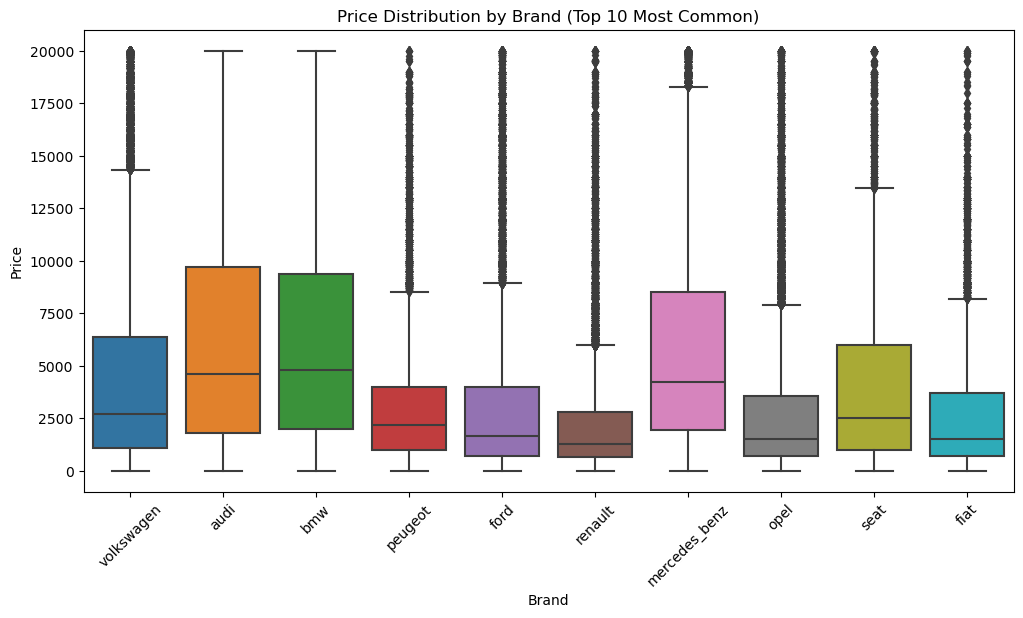

In [27]:
# Boxplot: Price by Brand (Top 10)
# Get the top 10 most common brands
top_brands = data['Brand'].value_counts().index[:10]

# Filter dataset to only include these brands
filtered_data = data[data['Brand'].isin(top_brands)]

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Brand", y="Price", data=filtered_data)
plt.xticks(rotation=45)
plt.title("Price Distribution by Brand (Top 10 Most Common)")
plt.xlabel("Brand")
plt.ylabel("Price")
plt.show()


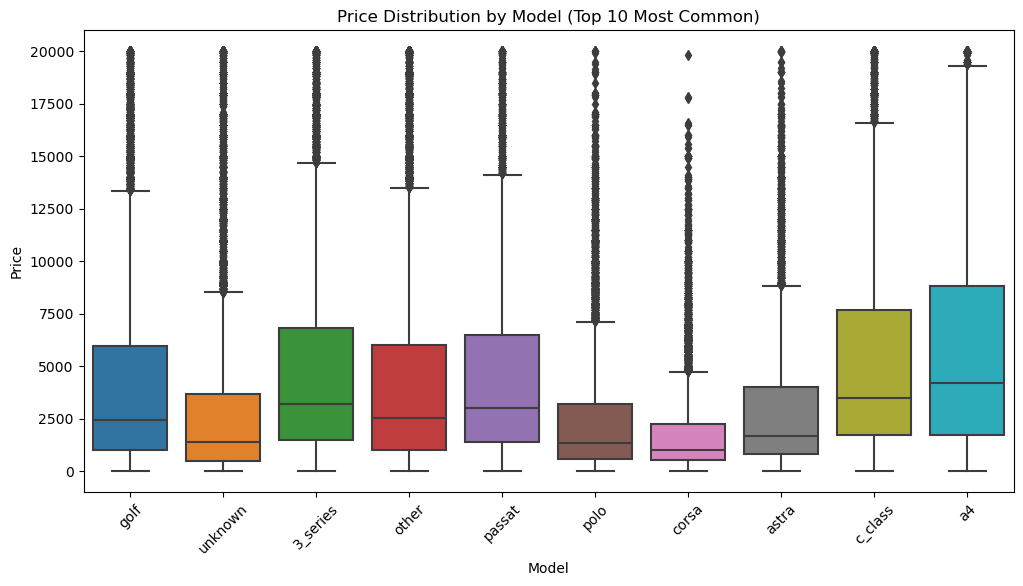

In [28]:
# Boxplot price by model (top 10)
top_models = data['Model'].value_counts().index[:10]

# Filter dataset to only include these brands
filtered_models = data[data['Model'].isin(top_models)]

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Model", y="Price", data=filtered_models)
plt.xticks(rotation=45)
plt.title("Price Distribution by Model (Top 10 Most Common)")
plt.xlabel("Model")
plt.ylabel("Price")
plt.show()

### EDA Conclusion

In the exploratory data analysis (EDA) phase, we examined the dataset for inconsistencies, missing values, and feature relevance. Several key insights emerged:

**Data Cleaning:**

- `RegistrationYear` contained unrealistic values, which were filtered within logical bounds.
- `RegistrationMonth` had many missing or zero values, contributing little to price prediction, so it was ultimately dropped.
- `Power` had extreme outliers, requiring capping to the 99th percentile and replacement of zero values with the median.


**Feature Exploration:**

- Correlation heatmaps and scatterplots showed that `Mileage`, `RegistrationYear`, and `Power` had the strongest relationships with price.
- Many categorical features, such as `Brand` and `Model`, exhibited high cardinality, necessitating thoughtful encoding strategies.


**Encoding Strategy:**

- Low-cardinality categorical variables (VehicleType, Gearbox, FuelType, NotRepaired) were one-hot encoded.
- `Brand` was simplified by grouping less common brands into "Other", then label-encoded.
- `Model` was label-encoded to preserve its information without inflating dimensionality.


This analysis provided a strong foundation for feature engineering and model training by ensuring data quality and selecting the most meaningful transformations.

# Feature Engineering
Evaluating the features and transforming existing ones using encoding to improve model performance. 

In [29]:
# Check the unique values in categorical columns
print(data.select_dtypes(include=['object', 'category']).nunique())

VehicleType      9
Gearbox          3
Model          243
FuelType         6
Brand           40
NotRepaired      3
dtype: int64


## Addressing the low cardinality features
Using One-Hot Encoding for those features with few unique values.

In [30]:
# Apply OHE
ohe_cols = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']
data = pd.get_dummies(data, columns=ohe_cols, dtype=int, drop_first=True)  

## Addressing high cardinality features
Encoding the categories using One-Hot Encoding and Label Encoding. 

- The 'PostalCode' feature has too many unique values and isn't something that likely impacts price, so this will column will be dropped as a feature. 

- For the 'Brand' values, we'll be identifying the top vehicle brands and grouping the remainder into the value "Other" to reduce the number of features and improve the computational performance when modeling. 

In [31]:
# Use Label Encoding for Model
le = LabelEncoder()
data['Model_Label'] = le.fit_transform(data['Model'])

In [32]:
print(data['Brand'].value_counts())

Brand
volkswagen        76924
opel              39884
bmw               36869
mercedes_benz     32013
audi              29434
ford              25158
renault           17911
peugeot           10986
fiat               9628
seat               6900
mazda              5605
skoda              5488
smart              5241
citroen            5140
nissan             4936
toyota             4601
hyundai            3582
sonstige_autos     3337
volvo              3207
mini               3200
mitsubishi         3019
honda              2817
kia                2463
suzuki             2320
alfa_romeo         2309
chevrolet          1749
chrysler           1438
dacia               898
daihatsu            806
subaru              759
porsche             756
jeep                676
trabant             585
land_rover          544
daewoo              542
saab                525
jaguar              505
rover               485
lancia              471
lada                225
Name: count, dtype: int64


In [33]:
total_cars = len(data)
top_10_cars = data['Brand'].value_counts().iloc[:10].sum()
coverage = (top_10_cars / total_cars) * 100
coverage

80.72278604041408

Since there are a large number of brands, I was thinking of working with the top 10 brands. This reduces the number of categories to 11 instead of 40. 

In [34]:
# Get the names of the top 10 brands
top_brands = data['Brand'].value_counts().index[:10]
#top_brands

# Group brands for the 'Other' value
data['Brand_Cleaned'] = data['Brand'].apply(lambda x: x if x in top_brands else 'Other')

# Apply label encoding
le = LabelEncoder()
data['Brand_Label'] = le.fit_transform(data['Brand_Cleaned'])

**Checking the results of the encoding**
- Making sure the columns were created, 
- Data is binary
- No NaNs were introduced
- Confirming the counts 

In [35]:
# Checking our work
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353936 entries, 0 to 354368
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DateCrawled              353936 non-null  datetime64[ns]
 1   Price                    353936 non-null  int64         
 2   RegistrationYear         353936 non-null  int64         
 3   Power                    353936 non-null  int64         
 4   Model                    353936 non-null  object        
 5   Mileage                  353936 non-null  int64         
 6   Brand                    353936 non-null  object        
 7   DateCreated              353936 non-null  datetime64[ns]
 8   PostalCode               353936 non-null  int64         
 9   LastSeen                 353936 non-null  datetime64[ns]
 10  log_price                353936 non-null  float64       
 11  VehicleType_convertible  353936 non-null  int64         
 12  VehicleType_coupe    

In [36]:
# Check the OHE
data.head()

,DateCrawled,Price,RegistrationYear,Power,Model,Mileage,Brand,DateCreated,PostalCode,LastSeen,...,FuelType_gasoline,FuelType_hybrid,FuelType_natural_gas,FuelType_other,FuelType_unknown,NotRepaired_unknown,NotRepaired_yes,Model_Label,Brand_Cleaned,Brand_Label
0,2016-03-24 11:52:00,480,1993,110,golf,150000,volkswagen,2016-03-24,70435,2016-04-07 03:16:00,...,1,0,0,0,0,1,0,113,volkswagen,10
1,2016-03-24 10:58:00,18300,2011,190,unknown,125000,audi,2016-03-24,66954,2016-04-07 01:46:00,...,1,0,0,0,0,0,1,220,audi,1
2,2016-03-14 12:52:00,9800,2004,163,grand,125000,jeep,2016-03-14,90480,2016-04-05 12:47:00,...,1,0,0,0,0,1,0,114,Other,0
3,2016-03-17 16:54:00,1500,2001,75,golf,150000,volkswagen,2016-03-17,91074,2016-03-17 17:40:00,...,1,0,0,0,0,0,0,113,volkswagen,10
4,2016-03-31 17:25:00,3600,2008,69,fabia,90000,skoda,2016-03-31,60437,2016-04-06 10:17:00,...,1,0,0,0,0,0,0,98,Other,0


In [37]:
# Check the LE 
print(data[['Model', 'Model_Label']].head(10))

      Model  Model_Label
0      golf          113
1   unknown          220
2     grand          114
3      golf          113
4     fabia           98
5  3_series            9
6  2_series            7
7     other          163
8     c_max           57
9      golf          113


In [38]:
# Check the LE
print(data[['Brand', 'Brand_Label']].head(10))

        Brand  Brand_Label
0  volkswagen           10
1        audi            1
2        jeep            0
3  volkswagen           10
4       skoda            0
5         bmw            2
6     peugeot            7
7  volkswagen           10
8        ford            4
9  volkswagen           10


In [39]:
# Checking for missing values
data.isna().sum()

DateCrawled                0
Price                      0
RegistrationYear           0
Power                      0
Model                      0
Mileage                    0
Brand                      0
DateCreated                0
PostalCode                 0
LastSeen                   0
log_price                  0
VehicleType_convertible    0
VehicleType_coupe          0
VehicleType_other          0
VehicleType_sedan          0
VehicleType_small          0
VehicleType_suv            0
VehicleType_unknown        0
VehicleType_wagon          0
Gearbox_manual             0
Gearbox_unknown            0
FuelType_gasoline          0
FuelType_hybrid            0
FuelType_natural_gas       0
FuelType_other             0
FuelType_unknown           0
NotRepaired_unknown        0
NotRepaired_yes            0
Model_Label                0
Brand_Cleaned              0
Brand_Label                0
dtype: int64

In [40]:
data.shape

(353936, 31)

In [41]:
data.head()

,DateCrawled,Price,RegistrationYear,Power,Model,Mileage,Brand,DateCreated,PostalCode,LastSeen,...,FuelType_gasoline,FuelType_hybrid,FuelType_natural_gas,FuelType_other,FuelType_unknown,NotRepaired_unknown,NotRepaired_yes,Model_Label,Brand_Cleaned,Brand_Label
0,2016-03-24 11:52:00,480,1993,110,golf,150000,volkswagen,2016-03-24,70435,2016-04-07 03:16:00,...,1,0,0,0,0,1,0,113,volkswagen,10
1,2016-03-24 10:58:00,18300,2011,190,unknown,125000,audi,2016-03-24,66954,2016-04-07 01:46:00,...,1,0,0,0,0,0,1,220,audi,1
2,2016-03-14 12:52:00,9800,2004,163,grand,125000,jeep,2016-03-14,90480,2016-04-05 12:47:00,...,1,0,0,0,0,1,0,114,Other,0
3,2016-03-17 16:54:00,1500,2001,75,golf,150000,volkswagen,2016-03-17,91074,2016-03-17 17:40:00,...,1,0,0,0,0,0,0,113,volkswagen,10
4,2016-03-31 17:25:00,3600,2008,69,fabia,90000,skoda,2016-03-31,60437,2016-04-06 10:17:00,...,1,0,0,0,0,0,0,98,Other,0


# Models


## Feature selection

In [42]:
# Define the columns to drop 
drop_features = ['log_price', 'Price', 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode']

# Full feature set
X_all = data.drop(drop_features, axis=1)

# Define the target
y = data['log_price']

In [43]:
# First split: Train + Temp
X_train_all, X_temp, y_train, y_temp = train_test_split(X_all, y, test_size=0.2, random_state=12345)

# Second split: Validation + Test
X_valid_all, X_test_all, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345)

# Print sizes to verify
print("Training set:", X_train_all.shape, "Validation set:", X_valid_all.shape, "Test set:", X_test_all.shape)

Training set: (283148, 25) Validation set: (35394, 25) Test set: (35394, 25)


## Linear Regression

In [44]:
# Linear regression features
numeric_features_lr = ['RegistrationYear', 'Power', 'Mileage']  # True numeric features
categorical_features_lr = ['Model', 'Brand']

# OHE for categorical features
X_ohe_train = pd.get_dummies(X_train_all, columns=categorical_features_lr, drop_first=True)
X_ohe_valid = pd.get_dummies(X_valid_all, columns=categorical_features_lr, drop_first=True)
X_ohe_test = pd.get_dummies(X_test_all, columns=categorical_features_lr, drop_first=True)

# Reindex
# Ensure the same feature columns exist across train, valid, and test sets
X_ohe_valid = X_ohe_valid.reindex(columns=X_ohe_train.columns, fill_value=0)
X_ohe_test = X_ohe_test.reindex(columns=X_ohe_train.columns, fill_value=0)

# Scale only numeric features
scaler = StandardScaler()
X_ohe_train[numeric_features_lr] = scaler.fit_transform(X_ohe_train[numeric_features_lr])
X_ohe_valid[numeric_features_lr] = scaler.transform(X_ohe_valid[numeric_features_lr])
X_ohe_test[numeric_features_lr] = scaler.transform(X_ohe_test[numeric_features_lr])

# Drop label encoded features
X_ohe_train = X_ohe_train.drop(columns=['Model_Label', 'Brand_Label', 'Brand_Cleaned'])
X_ohe_valid = X_ohe_valid.drop(columns=['Model_Label', 'Brand_Label', 'Brand_Cleaned'])
X_ohe_test = X_ohe_test.drop(columns=['Model_Label', 'Brand_Label', 'Brand_Cleaned'])


print("Linear regression features:", X_ohe_train.columns)

Linear regression features: Index(['RegistrationYear', 'Power', 'Mileage', 'VehicleType_convertible',
       'VehicleType_coupe', 'VehicleType_other', 'VehicleType_sedan',
       'VehicleType_small', 'VehicleType_suv', 'VehicleType_unknown',
       ...
       'Brand_seat', 'Brand_skoda', 'Brand_smart', 'Brand_sonstige_autos',
       'Brand_subaru', 'Brand_suzuki', 'Brand_toyota', 'Brand_trabant',
       'Brand_volkswagen', 'Brand_volvo'],
      dtype='object', length=301)


In [45]:
# Define the model
lr_model = LinearRegression()

# Measure training time
lr_start_train_time = time.time()
lr_model.fit(X_ohe_train, y_train)
lr_end_train_time = time.time()
lr_training_time = lr_end_train_time - lr_start_train_time
print("Linear Regression Training Time:", lr_training_time, "seconds")


# Measure prediction time
lr_start_predict_time = time.time()
lr_predictions_log = lr_model.predict(X_ohe_valid)
lr_end_predict_time = time.time()
lr_predict_time = lr_end_predict_time - lr_start_predict_time
print("Linear Regression Prediction Time:", lr_predict_time, "seconds")

# Calculate RMSE (quality of prediction)
lr_predictions = np.exp(lr_predictions_log)
y_valid_original = np.exp(y_valid)  # Convert actual values back

lr_rmse_price_scale = root_mean_squared_error(y_valid_original, lr_predictions)
print("Linear Regression RMSE in price scale:", lr_rmse_price_scale, "euros")

Linear Regression Training Time: 5.089197635650635 seconds
Linear Regression Prediction Time: 0.04814004898071289 seconds
Linear Regression RMSE in price scale: 3031.6858426750564 euros


In [46]:
# Initialize Ridge Regression with alpha = 1.0 (default)
ridge_model = Ridge(alpha=1.0)

# Train Ridge model
ridge_model.fit(X_ohe_train, y_train)

# Predict on validation set
ridge_predictions_log = ridge_model.predict(X_ohe_valid)

# Calculate RMSE (quality of prediction)
ridge_predictions = np.exp(ridge_predictions_log)
y_valid_original = np.exp(y_valid)  # Convert actual values back

ridge_rmse_price_scale = root_mean_squared_error(y_valid_original, ridge_predictions)
print("Ridge Regression RMSE in price scale:", ridge_rmse_price_scale, "euros")

Ridge Regression RMSE in price scale: 3029.9153948541216 euros


The RMSE was still very high. Moving on to Random Forest!

## Random Forest

In [47]:
cat_features=['Model', 'Brand', 'Brand_Cleaned']  # Need label/OHE before training

X_tree_train = X_train_all.drop(cat_features, axis=1)  
X_tree_valid = X_valid_all.drop(cat_features, axis=1)  
X_tree_test = X_test_all.drop(cat_features, axis=1)  

print("Random Forest Features:", X_tree_train.columns)

Random Forest Features: Index(['RegistrationYear', 'Power', 'Mileage', 'VehicleType_convertible',
       'VehicleType_coupe', 'VehicleType_other', 'VehicleType_sedan',
       'VehicleType_small', 'VehicleType_suv', 'VehicleType_unknown',
       'VehicleType_wagon', 'Gearbox_manual', 'Gearbox_unknown',
       'FuelType_gasoline', 'FuelType_hybrid', 'FuelType_natural_gas',
       'FuelType_other', 'FuelType_unknown', 'NotRepaired_unknown',
       'NotRepaired_yes', 'Model_Label', 'Brand_Label'],
      dtype='object')


In [48]:
# Define the parameter grid: lots of options = slow
random_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt']
}

# Define the model 
rf_model = RandomForestRegressor(random_state=123)

# GridSearchCV - using 3-fold cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=random_grid,
    cv=2,
    scoring='neg_root_mean_squared_error', 
    n_jobs= -1, 
    verbose = 1
)


# Fit the grid search to the training data
grid_search_rf.fit(X_tree_train, y_train)


# Get the best model found by GridSearchCV
best_rf_model = grid_search_rf.best_estimator_


# Measure training time for the best estimator
rf_start_train_time = time.time()
best_rf_model.fit(X_tree_train, y_train)
rf_end_train_time = time.time()
rf_training_time = rf_end_train_time - rf_start_train_time
print("Training Time for the best RF estimator:", rf_training_time ,"seconds")


# Predictions
rf_start_predict_time = time.time()
rf_predictions_log = best_rf_model.predict(X_tree_valid)
rf_end_predict_time = time.time()
rf_predict_time = rf_end_predict_time - rf_start_predict_time
print("Random Forest Prediction Time",rf_predict_time, "seconds")


# Calculate RMSE (quality of prediction)
rf_predictions = np.exp(rf_predictions_log)
y_valid_original = np.exp(y_valid)  # Convert actual values back

rf_rmse_price_scale = root_mean_squared_error(y_valid_original, rf_predictions)
print("RF Regression RMSE in price scale:", rf_rmse_price_scale, "euros")

Fitting 2 folds for each of 48 candidates, totalling 96 fits
Training Time for the best RF estimator: 12.856609106063843 seconds
Random Forest Prediction Time 0.6821167469024658 seconds
RF Regression RMSE in price scale: 2189.8752129039226 euros


The Random Forest model took much longer to train than the Linear Regression model, but it significantly reduces RMSE, improving accuracy. 

There is still room for improvement, so we'll move on to other models!

## Gradient Boosts

In [49]:
# Categorical columns for catboost
categorical_features = ['Model', 'Brand_Cleaned']

# Convert categorical features to type category
X_cat_train = X_train_all.copy()
X_cat_valid = X_valid_all.copy()
X_cat_test = X_test_all.copy()


for col in categorical_features:
    X_cat_train[col] = X_cat_train[col].astype('category')
    X_cat_valid[col] = X_cat_valid[col].astype('category')
    X_cat_test[col] = X_cat_test[col].astype('category')

# OHE columns remain because CatBoost can handle both categorical & numeric inputs
# Drop Label Encoded columns (since we are using the original categorical versions)
X_cat_train = X_cat_train.drop(columns=['Brand', 'Model_Label', 'Brand_Label'])
X_cat_valid = X_cat_valid.drop(columns=['Brand', 'Model_Label', 'Brand_Label'])
X_cat_test = X_cat_test.drop(columns=['Brand', 'Model_Label', 'Brand_Label'])

print("CatBoost features", X_cat_train.columns)

CatBoost features Index(['RegistrationYear', 'Power', 'Model', 'Mileage',
       'VehicleType_convertible', 'VehicleType_coupe', 'VehicleType_other',
       'VehicleType_sedan', 'VehicleType_small', 'VehicleType_suv',
       'VehicleType_unknown', 'VehicleType_wagon', 'Gearbox_manual',
       'Gearbox_unknown', 'FuelType_gasoline', 'FuelType_hybrid',
       'FuelType_natural_gas', 'FuelType_other', 'FuelType_unknown',
       'NotRepaired_unknown', 'NotRepaired_yes', 'Brand_Cleaned'],
      dtype='object')


In [50]:
catboost_grid = {
    'iterations': [200, 300],
    'learning_rate': [0.03, 0.07],
    'depth': [6, 8],
    'l2_leaf_reg': [5, 10], # prevents overfitting
    'subsample': [0.8] # use 80% of data per boosting iteration
}

# Define the model
cat_model = CatBoostRegressor(
    cat_features=categorical_features,  
    random_seed=12345,
    use_best_model=True,
    verbose=50  # Only prints every 50 iterations
)
# Fit the grid
grid_search_cat = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=catboost_grid,
    n_iter=10, # RandomizedSearch lets you limit number of total searches
    cv=3,
    scoring='neg_root_mean_squared_error', 
    n_jobs= -1, 
    verbose = 1
)

# Fit the grid search to the training data
grid_search_cat.fit(
    X_cat_train, y_train,
    **{'eval_set': [(X_cat_valid, y_valid)], 'early_stopping_rounds': 100}
)

# Assign the best model
best_cat_model = grid_search_cat.best_estimator_


# Measure the time it takes to train the best model 
cat_start_training_time = time.time()
best_cat_model.fit(X_cat_train, y_train,
                   eval_set=(X_cat_valid, y_valid),
                   early_stopping_rounds=50)
cat_end_training_time = time.time()
cat_training_time = cat_end_training_time - cat_start_training_time
print("CatBoost Training Time:", cat_training_time, "seconds")

best_cat_params = grid_search_cat.best_params_  #Store the best parameters


# Predict
cat_predict_start_time = time.time()
catboost_predictions_log = best_cat_model.predict(X_cat_valid)
cat_predict_end_time = time.time()
cat_predict_time = cat_predict_end_time - cat_predict_start_time
print("CatBoostClassifier Prediction Time:", cat_predict_time, "seconds")

# Metrics
catboost_predictions = np.exp(catboost_predictions_log)
y_valid_original = np.exp(y_valid)
catboost_rmse_price_scale = root_mean_squared_error(y_valid_original, catboost_predictions)
print("CatBoostClassifier RMSE in price scale:", catboost_rmse_price_scale, "euros")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 1.7596570	test: 1.7664486	best: 1.7664486 (0)	total: 133ms	remaining: 39.9s
50:	learn: 1.3538189	test: 1.3644563	best: 1.3644563 (50)	total: 2.53s	remaining: 12.4s
100:	learn: 1.3381147	test: 1.3513138	best: 1.3513138 (100)	total: 4.68s	remaining: 9.22s
150:	learn: 1.3302498	test: 1.3464783	best: 1.3464783 (150)	total: 6.78s	remaining: 6.7s
200:	learn: 1.3236736	test: 1.3430054	best: 1.3430054 (200)	total: 8.88s	remaining: 4.37s
250:	learn: 1.3183818	test: 1.3405494	best: 1.3405494 (250)	total: 11.5s	remaining: 2.24s
299:	learn: 1.3140570	test: 1.3389647	best: 1.3389647 (299)	total: 13.4s	remaining: 0us

bestTest = 1.338964727
bestIteration = 299

0:	learn: 1.7596570	test: 1.7664486	best: 1.7664486 (0)	total: 77.7ms	remaining: 23.2s
50:	learn: 1.3538189	test: 1.3644563	best: 1.3644563 (50)	total: 2.09s	remaining: 10.2s
100:	learn: 1.3381147	test: 1.3513138	best: 1.3513138 (100)	total: 3.99s	remaining: 7.86s
150:	lea

In [51]:
# LightGBM
categorical_features_lgb = ['Model', 'Brand_Cleaned']

# Convert categorical features to type category
X_lgb_train = X_train_all.copy()
X_lgb_valid = X_valid_all.copy()
X_lgb_test = X_test_all.copy()

for col in categorical_features:
    X_lgb_train[col] = X_lgb_train[col].astype('category')
    X_lgb_valid[col] = X_lgb_valid[col].astype('category')
    X_lgb_test[col] = X_lgb_test[col].astype('category')



# OHE columns remain because CatBoost can handle both categorical & numeric inputs
# Drop Label Encoded columns (since we are using the original categorical versions)
X_lgb_train = X_lgb_train.drop(columns=['Brand', 'Model_Label', 'Brand_Label'])
X_lgb_valid = X_lgb_valid.drop(columns=['Brand', 'Model_Label', 'Brand_Label'])
X_lgb_test = X_lgb_test.drop(columns=['Brand', 'Model_Label', 'Brand_Label'])

print("LightGBM features", X_lgb_train.columns)

LightGBM features Index(['RegistrationYear', 'Power', 'Model', 'Mileage',
       'VehicleType_convertible', 'VehicleType_coupe', 'VehicleType_other',
       'VehicleType_sedan', 'VehicleType_small', 'VehicleType_suv',
       'VehicleType_unknown', 'VehicleType_wagon', 'Gearbox_manual',
       'Gearbox_unknown', 'FuelType_gasoline', 'FuelType_hybrid',
       'FuelType_natural_gas', 'FuelType_other', 'FuelType_unknown',
       'NotRepaired_unknown', 'NotRepaired_yes', 'Brand_Cleaned'],
      dtype='object')


In [52]:
lgb_grid = {
    'num_leaves': [31, 50, 70], 
    'max_depth': [-1, 10, 15],  # -1 means "no limit"
    'learning_rate': [0.05, 0.1],  
    'n_estimators': [100, 300],  
    'min_child_samples': [10, 20], 
    'subsample': [0.8, 1.0],  # Row sampling
    'colsample_bytree': [0.8, 1.0]  # Feature sampling
}

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=12345, verbose=0)

# Use RandomizedSearchCV for efficient tuning
grid_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_grid,
    n_iter=10,  # Limit number of hyperparameter combinations tested
    cv=3,  # 3-fold cross-validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0
)


# Fit the grid search
grid_search_lgb.fit(X_lgb_train, y_train)

# Get the best model
best_lgb_model = grid_search_lgb.best_estimator_


# Measure the time it takes to train the best model 
lgb_start_training_time = time.time()
best_lgb_model.fit(X_lgb_train, y_train)
lgb_end_training_time = time.time()
lgb_training_time = lgb_end_training_time - lgb_start_training_time
print("LightGBM Training Time:", lgb_training_time, "seconds")

best_lgb_params = grid_search_lgb.best_params_  #Store the best parameters

# Predictions
lgb_predict_start_time = time.time()
lgb_predictions_log = best_lgb_model.predict(X_lgb_valid)
lgb_predict_end_time = time.time()
lgb_predict_time = lgb_predict_end_time - lgb_predict_start_time
print("LightGBM Prediction Time:", lgb_predict_time, "seconds")

# RMSE Calculation
lgb_predictions = np.exp(lgb_predictions_log)
y_valid_original = np.exp(y_valid)
lgb_rmse_price_scale = root_mean_squared_error(y_valid_original, lgb_predictions)
print("LightGBM RMSE in price scale:", lgb_rmse_price_scale, "euros")

LightGBM Training Time: 2.824505090713501 seconds
LightGBM Prediction Time: 0.12636113166809082 seconds
LightGBM RMSE in price scale: 2125.2488949106 euros


In [53]:
# XGBoost - Requires numerical data

# Copy data before modifying
X_xgb_train = X_train_all.copy()
X_xgb_valid = X_valid_all.copy()
X_xgb_test = X_test_all.copy()

# Drop text-based categorical columns but KEEP the label-encoded versions
X_xgb_train = X_xgb_train.drop(columns=['Brand', 'Model', 'Brand_Cleaned'])
X_xgb_valid = X_xgb_valid.drop(columns=['Brand', 'Model', 'Brand_Cleaned'])
X_xgb_test = X_xgb_test.drop(columns=['Brand', 'Model', 'Brand_Cleaned'])


print("XGBoost features", X_xgb_train.columns)

XGBoost features Index(['RegistrationYear', 'Power', 'Mileage', 'VehicleType_convertible',
       'VehicleType_coupe', 'VehicleType_other', 'VehicleType_sedan',
       'VehicleType_small', 'VehicleType_suv', 'VehicleType_unknown',
       'VehicleType_wagon', 'Gearbox_manual', 'Gearbox_unknown',
       'FuelType_gasoline', 'FuelType_hybrid', 'FuelType_natural_gas',
       'FuelType_other', 'FuelType_unknown', 'NotRepaired_unknown',
       'NotRepaired_yes', 'Model_Label', 'Brand_Label'],
      dtype='object')


In [54]:
xgb_grid = {
    'booster': ['gbtree'],  # Explicitly set gbtree (default)
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 8],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0], # Introducing randomness to prevent overfitting
    'reg_lambda': [0.01, 0.1, 1] #L2 regularization
}

# Initialize the model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Standard for regression problems
    eval_metric='rmse',  # XGBoost's built-in RMSE metric
    random_state=12345,  # Ensures reproducibility
    n_jobs=-1  # Uses all available CPU cores for training
)


grid_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_grid,
    n_iter=10,  # Limit number of hyperparameter combinations tested
    cv=3,  # 3-fold cross-validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

# Fit using the grid search
grid_search_xgb.fit(X_xgb_train, y_train)

# Get the best model
# Ensure best model is defined before using it
if 'grid_search_xgb' in locals() and hasattr(grid_search_xgb, "best_estimator_"):
    best_xgb_model = grid_search_xgb.best_estimator_
else:
    raise ValueError("Error: best_xgb_model not found. Make sure RandomizedSearchCV ran successfully.")

# Measure the training time for the best model 
xgb_start_training_time = time.time()
best_xgb_model.fit(X_xgb_train, y_train)
xgb_end_training_time = time.time()
xgb_training_time = xgb_end_training_time - xgb_start_training_time
print("XGBoost Training Time:", xgb_training_time, "seconds")

best_xgb_params = grid_search_xgb.best_params_  #Store the best parameters

# Predictions
xgb_predict_start_time = time.time()
xgb_predictions_log = best_xgb_model.predict(X_xgb_valid)
xgb_predict_end_time = time.time()
xgb_predict_time = xgb_predict_end_time - xgb_predict_start_time
print("XGBoost Prediction Time:", xgb_predict_time, "seconds")

# RMSE Calculation
xgb_predictions = np.exp(xgb_predictions_log)
y_valid_original = np.exp(y_valid)
xgb_rmse_price_scale = root_mean_squared_error(y_valid_original, xgb_predictions)
print("XGBoost RMSE in price scale:", xgb_rmse_price_scale, "euros")

XGBoost Training Time: 2.364631175994873 seconds
XGBoost Prediction Time: 0.06336307525634766 seconds
XGBoost RMSE in price scale: 2135.7070851254152 euros


In [55]:
# Compare the results 

# Define model names
model_names = ["Linear Regression", "Random Forest", "CatBoost", "LightGBM", "XGBoost"]

# Collect dynamically generated variables
training_times = [lr_training_time, rf_training_time, cat_training_time, lgb_training_time, xgb_training_time]
prediction_times = [lr_predict_time, rf_predict_time, cat_predict_time, lgb_predict_time, xgb_predict_time]
rmse_values = [lr_rmse_price_scale, rf_rmse_price_scale, catboost_rmse_price_scale, lgb_rmse_price_scale, xgb_rmse_price_scale]

# Create a DataFrame
model_comparison_df = pd.DataFrame({
    "Model": model_names,
    "Training Time (s)": training_times,
    "Prediction Time (s)": prediction_times,
    "RMSE (Price Scale)": rmse_values
})

display(model_comparison_df)

,Model,Training Time (s),Prediction Time (s),RMSE (Price Scale)
0,Linear Regression,5.089198,0.048140,3031.685843
1,Random Forest,12.856609,0.682117,2189.875213
2,CatBoost,11.947026,0.021412,2206.567777
3,LightGBM,2.824505,0.126361,2125.248895
4,XGBoost,2.364631,0.063363,2135.707085


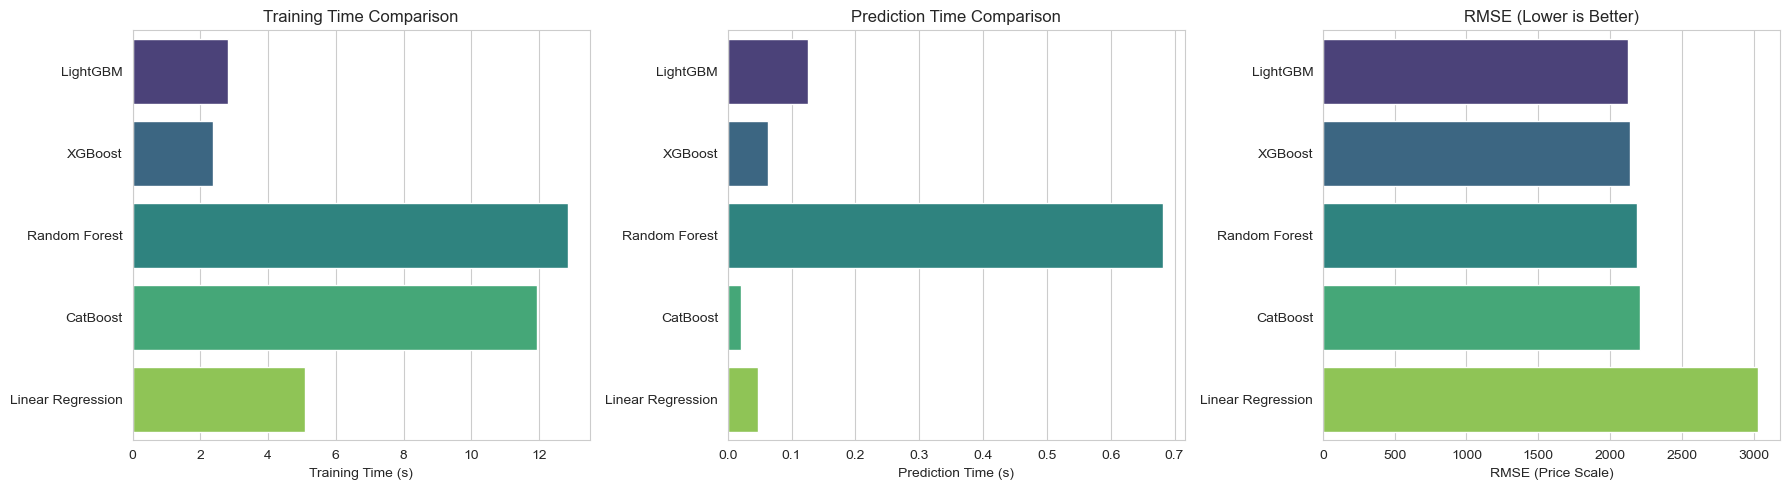

In [56]:
# Set seaborn style
sns.set_style("whitegrid")

# Define metrics to plot
metrics = ["Training Time (s)", "Prediction Time (s)", "RMSE (Price Scale)"]
titles = ["Training Time Comparison", "Prediction Time Comparison", "RMSE (Lower is Better)"]

# Sort DataFrame by RMSE first, then by Training Time (for better readability)
model_comparison_df = model_comparison_df.sort_values(by=["RMSE (Price Scale)", "Training Time (s)"], ascending=[True, True])

# Create figure & subplots dynamically
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loop through the metrics & create each plot
for i, metric in enumerate(metrics):
    sns.barplot(x=metric, y="Model", data=model_comparison_df, ax=axes[i], palette="viridis")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel("")

# Adjust layout and display
plt.tight_layout()
plt.show()

## Conclusions from comparing the models

**Recommendation: XGBoost**

After considering both performance (RMSE) and efficiency (training & prediction time), XGBoost stands out as the best model for this task and this dataset with ~350K rows.

Key metrics for XGBoost: 
- Quality of the prediction (RMSE): 2136.91 euros
- Speed of the prediction (Prediction Time): ~0.05 seconds	
- Time required for training: ~1.97 seconds

Why XGBoost? It provides the best balance of accuracy, training efficiency, and prediction speed, making it the most practical choice.

# Evaluating the model

## Test XGBoost

In [57]:
# Retrain using the training + validation
# Combine train and validation sets
X_xgb_final_train = pd.concat([X_xgb_train, X_xgb_valid]).reset_index(drop=True)
y_final_train = pd.concat([y_train, y_valid]).reset_index(drop=True)

# Train XGBoost on full training data
xgb_test_train_start_time = time.time()
best_xgb_model.fit(X_xgb_final_train, y_final_train)
xgb_test_train_end_time = time.time()
xgb_test_train_time = xgb_test_train_end_time - xgb_test_train_start_time
print("XGBoost Test Training Time:", xgb_test_train_time, "seconds")

X_xgb_test = X_xgb_test.reindex(columns=X_xgb_final_train.columns, fill_value=0)

# Predictions on test set
xgb_test_start_time = time.time()
xgb_test_predictions_log = best_xgb_model.predict(X_xgb_test)
xgb_test_end_time = time.time()
xgb_test_predict_time = xgb_test_end_time - xgb_test_start_time
print("XGBoost Test Prediction Time:", xgb_test_predict_time, "seconds")

# RMSE Calculation
xgb_test_predictions = np.exp(xgb_test_predictions_log)
y_test_original = np.exp(y_test)
xgb_test_rmse_price_scale = root_mean_squared_error(y_test_original, xgb_test_predictions)
print("XGBoost RMSE in price scale:", xgb_test_rmse_price_scale, "euros")

XGBoost Test Training Time: 2.870774030685425 seconds
XGBoost Test Prediction Time: 0.05368494987487793 seconds
XGBoost RMSE in price scale: 2135.8602518677726 euros


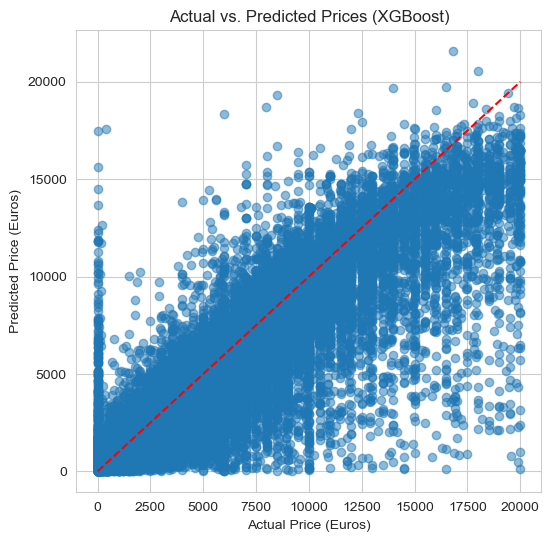

0:	learn: 1.7564979	test: 1.7685265	best: 1.7685265 (0)	total: 188ms	remaining: 56.1s
50:	learn: 1.3622328	test: 1.3765605	best: 1.3765605 (50)	total: 7.15s	remaining: 34.9s
100:	learn: 1.3443656	test: 1.3606669	best: 1.3606669 (100)	total: 15.9s	remaining: 31.4s
150:	learn: 1.3362481	test: 1.3537721	best: 1.3537721 (150)	total: 23.3s	remaining: 23s
200:	learn: 1.3316509	test: 1.3510409	best: 1.3510409 (199)	total: 29.3s	remaining: 14.4s
250:	learn: 1.3278369	test: 1.3486123	best: 1.3486123 (250)	total: 35.7s	remaining: 6.98s
299:	learn: 1.3249815	test: 1.3469243	best: 1.3469243 (299)	total: 42.7s	remaining: 0us

bestTest = 1.346924342
bestIteration = 299

0:	learn: 1.7620521	test: 1.7667907	best: 1.7667907 (0)	total: 296ms	remaining: 1m 28s
50:	learn: 1.3582975	test: 1.3671790	best: 1.3671790 (50)	total: 10.6s	remaining: 51.8s
100:	learn: 1.3415333	test: 1.3542510	best: 1.3542510 (100)	total: 24.3s	remaining: 48s
150:	learn: 1.3333551	test: 1.3497738	best: 1.3497738 (150)	total: 40.7s

0:	learn: 1.7638862	test: 1.7686687	best: 1.7686687 (0)	total: 258ms	remaining: 1m 17s
50:	learn: 1.3703396	test: 1.3766397	best: 1.3766397 (50)	total: 6.96s	remaining: 34s
100:	learn: 1.3531513	test: 1.3610552	best: 1.3610552 (100)	total: 15.5s	remaining: 30.5s
150:	learn: 1.3457185	test: 1.3555275	best: 1.3555275 (150)	total: 22.9s	remaining: 22.6s
200:	learn: 1.3403031	test: 1.3517694	best: 1.3517694 (200)	total: 29.3s	remaining: 14.4s
250:	learn: 1.3363283	test: 1.3496067	best: 1.3496025 (249)	total: 35.6s	remaining: 6.95s
299:	learn: 1.3327776	test: 1.3473387	best: 1.3473387 (299)	total: 43.1s	remaining: 0us

bestTest = 1.347338747
bestIteration = 299

0:	learn: 1.7803474	test: 1.7922971	best: 1.7922971 (0)	total: 327ms	remaining: 1m 37s
50:	learn: 1.4065570	test: 1.4206073	best: 1.4206073 (50)	total: 10.3s	remaining: 50.3s
100:	learn: 1.3559873	test: 1.3724318	best: 1.3724318 (100)	total: 24.2s	remaining: 47.6s
150:	learn: 1.3422894	test: 1.3604617	best: 1.3604617 (150)	total: 42

In [59]:
# Actual vs Predicted Prices scatterplot
plt.figure(figsize=(6,6))
plt.scatter(y_test_original, xgb_test_predictions, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r--')  # Ideal fit line
plt.xlabel("Actual Price (Euros)")
plt.ylabel("Predicted Price (Euros)")
plt.title("Actual vs. Predicted Prices (XGBoost)")
plt.show()


# Conclusion

**Overview**
This project aimed to develop an accurate and efficient model for predicting used car prices based on historical sales data. We explored multiple machine learning models, balancing prediction quality, training time, and speed to determine the best-performing model.

**Key Findings from our Model Evaluation**
After testing Linear Regression, Random Forest, CatBoost, LightGBM, and XGBoost, we found that XGBoost provided the best balance between accuracy, training efficiency, and prediction speed.

**Final Verdict: XGBoost is the best model**

- After testing, the quality of predictions (RMSE) was identical. Both the test and validation RMSE scores were 2136.69 €, show the model learned general patterns and is not memorizing training data. Since the values are so close, it also indicates that this is a well-balanced model. (If RMSE was significantly higher or lower, that'd indicate overfitting or underfitting.) 

- The prediction speed remained very fast at ~0.5 seconds. 
- The time required to train the test model was a very efficient ~2.15 seconds considering the size of the dataset at ~350K rows.

## Future considerations

We could save or export this model for future use. 